#  Variables categóricas

Las **variables categóricas** son un concepto fundamental en ciencia de datos: representan etiquetas o categorías discretas, como “País”, “Estación del año” o “Diagnóstico”. A diferencia de las variables numéricas, no tienen un orden o distancia natural entre valores (salvo que se especifique lo contrario, como en variables **ordinales**). Elegir una codificación adecuada es clave para que los modelos interpreten estas variables correctamente y para evitar introducir relaciones u **jerarquías no deseadas**.


## El problema de codificar con enteros simples

Una solución ingenua consiste en asignar **enteros** a cada categoría.

Por ejemplo, en un conjunto con información categórica como “Género”, “Grupo sanguíneo {A, B, AB, O}” o “Tipo de tratamiento”, asignar {A=0, B=1, AB=2, O=3} parece cómodo.

Sin embargo, esta codificación **impone un orden artificial** (0 < 1 < 2 < 3) y sugiere **distancias lineales** entre categorías que no existen. Muchos modelos (p. ej., regresión lineal, SVM lineales) podrían interpretar estos números como magnitudes u ordenaciones reales y extraer conclusiones erróneas.


In [23]:
import pandas as pd

# Example dataset with categorical data
data = {'Patient': ['A', 'B', 'C', 'D'], 
        'Blood_Type': ['A', 'B', 'AB', 'O']}
df_blood = pd.DataFrame(data)

# Simple integer encoding (problematic)
df_blood['Blood_Type_Encoded'] = df_blood['Blood_Type'].astype('category').cat.codes
display(df_blood)


Patient Blood_Type  Blood_Type_Encoded
0       A          A                   0
1       B          B                   2
2       C         AB                   1
3       D          O                   3

### *One‑Hot Encoding*

El *one‑hot encoding* soluciona este problema representando cada categoría con un **vector binario**: una columna por categoría; un valor 1 indica la presencia de la categoría y 0 en caso contrario. Esto evita introducir órdenes ficticios entre categorías.


In [24]:
# One-Hot Encoding Example
df_onehot = pd.get_dummies(df_blood['Blood_Type'], prefix='Blood_Type')
display(df_onehot)


Blood_Type_A  Blood_Type_AB  Blood_Type_B  Blood_Type_O
0          True          False         False         False
1         False          False          True         False
2         False           True         False         False
3         False          False         False          True

Un *one‑hot* crea **columnas separadas** para cada categoría (p. ej., `hospital_General`, `hospital_Clinica`, `hospital_Especializado`) con valores 0/1. Es simple y fácil de interpretar, pero utiliza **un bit más** de lo estrictamente necesario.
Si vemos que $k-1$ de los bits son 0, entonces el último bit debe ser 1 porque la variable debe tomar uno de los $k$ valores.
Matemáticamente, esta restricción puede escribirse como: “la **suma de todos los bits** debe ser igual a 1”.

$$
e_1 + e_2 + \dots + e_k = 1
$$


Supongamos que queremos predecir el **coste medio de tratamiento** y tenemos una variable categórica con tres hospitales: “General Hospital”, “City Clinic” y “Specialized Center”. Con *one‑hot*, añadimos tres columnas binarias e incluimos un **término independiente** (*bias*). Cada coeficiente asociado a una columna indica la **diferencia** en el coste medio respecto a la referencia inducida por el intercepto.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model


In [26]:
# Create a sample dataframe with treatment cost data from three hospitals
df = pd.DataFrame({
    'Hospital': ['General', 'General', 'General', 'City Clinic', 'City Clinic', 'City Clinic', 'Specialized', 'Specialized', 'Specialized'],
    'Treatment_Cost': [5000, 5200, 5100, 4800, 4900, 4950, 6000, 6050, 6100]
})

df

Hospital  Treatment_Cost
0      General            5000
1      General            5200
2      General            5100
3  City Clinic            4800
4  City Clinic            4900
5  City Clinic            4950
6  Specialized            6000
7  Specialized            6050
8  Specialized            6100

In [27]:
# One-hot encode the 'Hospital' column
one_hot_df = pd.get_dummies(df, prefix=['Hospital'])

one_hot_df

Treatment_Cost  Hospital_City Clinic  Hospital_General  \
0            5000                 False              True   
1            5200                 False              True   
2            5100                 False              True   
3            4800                  True             False   
4            4900                  True             False   
5            4950                  True             False   
6            6000                 False             False   
7            6050                 False             False   
8            6100                 False             False   

   Hospital_Specialized  
0                 False  
1                 False  
2                 False  
3                 False  
4                 False  
5                 False  
6                  True  
7                  True  
8                  True

In [28]:
# Define the predictor variables and target variable
X = one_hot_df[['Hospital_City Clinic', 'Hospital_General', 'Hospital_Specialized']]
y = one_hot_df['Treatment_Cost']

In [29]:
# Create and fit a linear regression model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

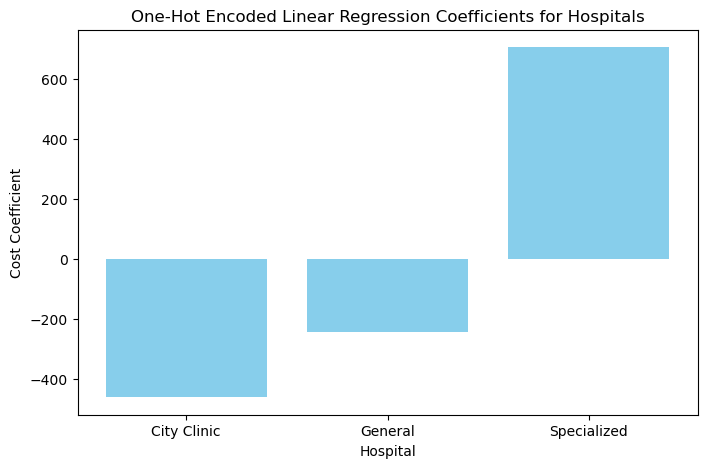

In [30]:
# Plotting the result
hospitals = ['City Clinic', 'General', 'Specialized']
coefficients = lin_reg.coef_

# Create a bar plot for the coefficients
plt.figure(figsize=(8, 5))
plt.bar(hospitals, coefficients, color='skyblue')
plt.xlabel('Hospital')
plt.ylabel('Cost Coefficient')
plt.title('One-Hot Encoded Linear Regression Coefficients for Hospitals')
plt.show()

In [31]:
# Get the model coefficients and intercept
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [-461.11111111 -244.44444444  705.55555556]
Intercept: 5344.444444444444


Con *one‑hot encoding*, el **término independiente** representa el **promedio global** (media de todas las observaciones). El coeficiente de una categoría concreta cuantifica **cuánto difiere** el promedio de esa categoría del promedio global (manteniendo el resto constante).


In [32]:
df['Treatment_Cost'].mean()

5344.444444444444

### *Dummy Coding*

El problema del *one‑hot* es la **multicolinealidad perfecta** si se incluyen todas las columnas junto con el intercepto: la suma de las dummies es 1. El *dummy coding* es similar al *one‑hot*, pero **elimina una categoría** (categoría de **referencia**). Así se evita la colinealidad y se mantienen modelos bien definidos.


In [33]:
# Dummy Encoding Example
df_dummy = pd.get_dummies(df_blood['Blood_Type'], drop_first=True, prefix='Blood_Type')
display(df_dummy)


Blood_Type_AB  Blood_Type_B  Blood_Type_O
0          False         False         False
1          False          True         False
2           True         False         False
3          False         False          True

El resultado de modelar con *dummy coding* suele ser **más interpretable** que con *one‑hot* completo, porque los coeficientes se entienden respecto a una **categoría de referencia**.


In [34]:
dummy_df = pd.get_dummies(df, prefix=['Hospital'], drop_first=True)
dummy_df

Treatment_Cost  Hospital_General  Hospital_Specialized
0            5000              True                 False
1            5200              True                 False
2            5100              True                 False
3            4800             False                 False
4            4900             False                 False
5            4950             False                 False
6            6000             False                  True
7            6050             False                  True
8            6100             False                  True

In [35]:
X = dummy_df[['Hospital_General', 'Hospital_Specialized']]
y = dummy_df['Treatment_Cost']

lin_reg.fit(X,y)

LinearRegression()

Con *dummy coding*, el **término independiente** (*bias*) representa la **media de la categoría de referencia** (por ejemplo, *City Clinic*). El coeficiente de la $i$‑ésima categoría indica **cuánto difiere** su media de la media de la categoría de referencia.


In [39]:
# Get the model coefficients and intercept
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [ 216.66666667 1166.66666667]
Intercept: 4883.333333333333


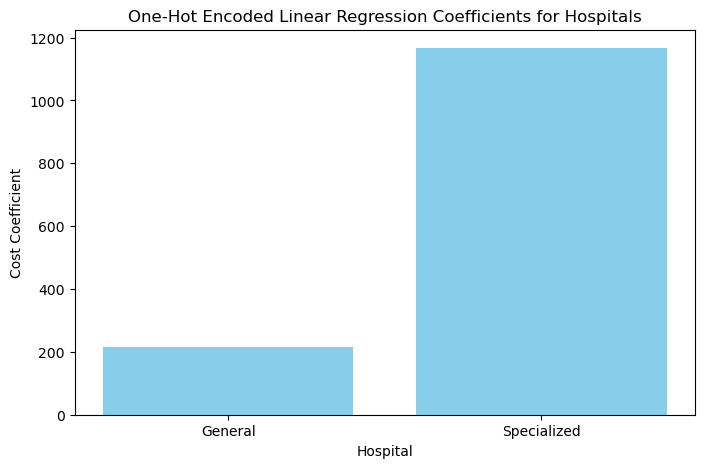

In [40]:
# Plotting the result
hospitals = [ 'General', 'Specialized']
coefficients = lin_reg.coef_

# Create a bar plot for the coefficients
plt.figure(figsize=(8, 5))
plt.bar(hospitals, coefficients, color='skyblue')
plt.xlabel('Hospital')
plt.ylabel('Cost Coefficient')
plt.title('One-Hot Encoded Linear Regression Coefficients for Hospitals')
plt.show()

## *Effect Coding*

El **effect coding** (o **contrast coding**) es muy parecido al *dummy coding*, pero usa valores en {−1, 0, 1} y aplica una **restricción de suma cero** entre las categorías. En lugar de eliminar la columna de referencia, se codifica con el **vector de todos −1**. Al ajustar una regresión con variables codificadas por *effect coding*, los coeficientes reflejan desvíos respecto a la **media global**, y la suma de los efectos por categoría es **cero**.


In [50]:
effect_df = dummy_df.copy()

In [52]:
effect_df.loc[3:5, ['Hospital_General', 'Hospital_Specialized']] = -1.0
effect_df

Treatment_Cost Hospital_General Hospital_Specialized
0            5000             True                False
1            5200             True                False
2            5100             True                False
3            4800             -1.0                 -1.0
4            4900             -1.0                 -1.0
5            4950             -1.0                 -1.0
6            6000            False                 True
7            6050            False                 True
8            6100            False                 True

Con *effect coding*, los resultados en modelos lineales son **interpretables a nivel de medias**: el intercepto representa la **media global** y cada coeficiente indica **cuánto se desvía** la media de esa categoría respecto a la global.


In [55]:
X = effect_df[['Hospital_General', 'Hospital_Specialized']]
y = effect_df['Treatment_Cost']

lin_reg.fit(X,y)

# Get the model coefficients and intercept
print("Coefficients:", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Coefficients: [-244.44444444  705.55555556]
Intercept: 5344.444444444444


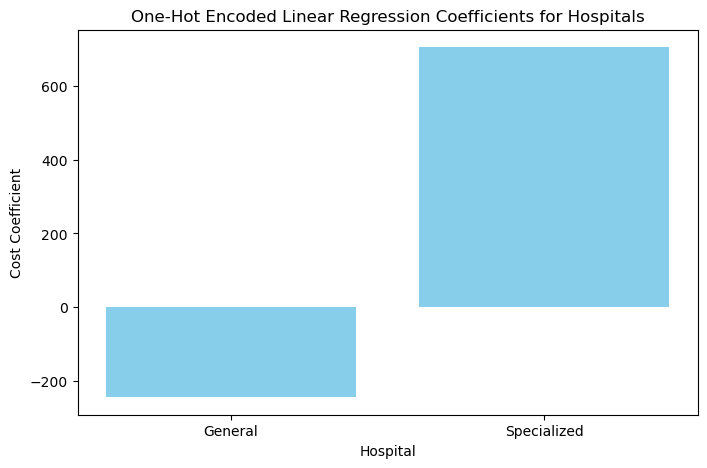

In [56]:
# Plotting the result
hospitals = ['General', 'Specialized']
coefficients = lin_reg.coef_

# Create a bar plot for the coefficients
plt.figure(figsize=(8, 5))
plt.bar(hospitals, coefficients, color='skyblue')
plt.xlabel('Hospital')
plt.ylabel('Cost Coefficient')
plt.title('One-Hot Encoded Linear Regression Coefficients for Hospitals')
plt.show()

### Ventajas e inconvenientes de las codificaciones de variables categóricas

- **One‑hot**: sencillo y robusto, pero **redundante** y con mala escalabilidad en **alta cardinalidad**.
- **Dummy coding**: evita colinealidad con intercepto y ofrece **comparación clara** contra una **categoría de referencia**.
- **Effect coding**: útil cuando interesa que los efectos **sumen cero** y comparar contra la **media global**.
- **Codificaciones supervisadas** (p. ej., *target encoding* / *count encoding*): capturan relación con el objetivo, pero requieren **regularización** para evitar fuga de información.
- **Métodos basados en árboles** suelen manejar categorías tras *one‑hot* o con técnicas propias; **modelos lineales** se benefician de *dummy/effect coding*; **hashing** y **embeddings** ayudan con **cardinalidad alta**.


| **Método**              | **Redundancia**        | **Manejo de alta cardinalidad** | **Sesgo/varianza**                | **Uso práctico** |
|-------------------------|------------------------|----------------------------------|-----------------------------------|------------------|
| One‑hot                 | Alta                   | Pobre                            | Bajo sesgo, varianza ↑ si muchas  | General/lineales |
| Dummy coding            | Menor que one‑hot      | Pobre                            | Interpretable (ref.)              | Lineales         |
| Effect coding           | Menor que one‑hot      | Pobre                            | Suma‑cero, efectos globales       | ANOVA/lineales   |
| Target/Count encoding   | Baja                   | Buena                            | Riesgo fuga info (regularizar)    | Alto cardinalidad|
| Feature hashing         | Baja                   | Excelente                         | Colisiones controlables           | Alto cardinalidad|


## Manejo de variables categóricas de **alta cardinalidad**

Cuando una variable tiene **muchas categorías** (p. ej., millones de IDs, genes o marcadores), las estrategias anteriores pueden volverse inviables. En estos casos, es habitual recurrir a **feature hashing**, **count/target encoding** o **embeddings** (en redes neuronales), que ofrecen representaciones compactas y eficaces.


### *Feature Hashing*

El *feature hashing* (o **hashing trick**) mapea categorías a un espacio de dimensión fija $d$ mediante funciones *hash*. Permite una representación **compacta** y evita mantener diccionarios enormes. Es especialmente útil en **alto cardinalidad** y flujos de datos.


El *feature hashing* mapea la categoría original $x \in \mathcal{X}$ a un vector disperso $\phi(x) \in \mathbb{R}^d$.
De forma típica, se usan dos funciones hash: una para elegir el **índice** en $[0, d)$ y otra para el **signo** ($\pm 1$),
de modo que:

- $h(x) \in \{0, \dots, d-1\}$ determina la posición activa;
- $\xi(x) \in \{-1, +1\}$ asigna el signo de la contribución;

lo que ayuda a **des‑sesgar** el efecto de **colisiones** inevitables al reducir dimensionalidad.


In [60]:
from sklearn.feature_extraction import FeatureHasher

# Example dataset with large categorical variable
df_large = pd.DataFrame({'Genetic_Marker': ['MarkerA', 'MarkerB', 'MarkerC', 'MarkerD', 'MarkerE']})

# Convert the Genetic_Marker column to a list of dictionaries
marker_dict = df_large['Genetic_Marker'].apply(lambda x: {x: 1}).tolist()

# Feature Hashing with 3 output features
hasher = FeatureHasher(n_features=3, input_type='dict')
hashed_features = hasher.transform(marker_dict)

# Convert the hashed features into a DataFrame
hashed_df = pd.DataFrame(hashed_features.toarray(), columns=[f'Feature_{i+1}' for i in range(3)])
display(hashed_df)


Feature_1  Feature_2  Feature_3
0        0.0        1.0        0.0
1        1.0        0.0        0.0
2       -1.0        0.0        0.0
3        0.0        0.0       -1.0
4       -1.0        0.0        0.0

### Colisiones
Un posible inconveniente del *hashing* son las **colisiones** (distintas categorías mapean al mismo índice). Aunque esto provoca cierta pérdida de información, el uso del **signo** $\xi(x)$ mitiga el sesgo. En la práctica, se elige una dimensión $d$ lo suficientemente grande para que las colisiones no degraden de forma apreciable el rendimiento del modelo.


### *Bin Counting* / *Count Encoding*

La idea es sencilla pero potente: en lugar de *one‑hot*, sustituir cada categoría por una **estadística** calculada a partir de los datos, por ejemplo:
- **recuento** de apariciones de la categoría,
- **frecuencia** normalizada,
- **probabilidad condicional** del objetivo dado la categoría (con regularización).

Esto capta la **fuerza de asociación** entre la categoría y la variable objetivo suponiendo independencia del resto de variables. En práctica, es útil en contextos médicos y de negocio con **datos escasos** o categorías raras, siempre aplicando **suavizado** y validación adecuada para evitar fuga de información.


In [62]:
# Example: Bin Counting for Categorical Variable
df_blood['Blood_Type_Count'] = df_blood['Blood_Type'].map(df_blood['Blood_Type'].value_counts())
display(df_blood)


Patient Blood_Type  Blood_Type_Encoded  Blood_Type_Count
0       A          A                   0                 1
1       B          B                   2                 1
2       C         AB                   1                 1
3       D          O                   3                 1

La selección y el preprocesado cuidadoso de variables categóricas **mejoran la generalización** y reducen la complejidad del modelo. La elección del método de codificación depende del **problema** y de las **características de los datos**.

- **Modelos lineales** (más ligeros) suelen beneficiarse de *dummy/effect coding* y *target/count encoding* con regularización.
- **Modelos basados en árboles** manejan bien variables tras *one‑hot*; el *hashing* es útil con cardinalidad muy alta.
- **Aprendizaje profundo** puede aprovechar **embeddings** que aprenden representaciones densas.

En conjunto, no existe una única mejor opción: conviene **probar y validar** varias estrategias.
